# LightGBM: Training

- load best parameters from hyperparameter tuning
- load data and prepare for training
- fit and save model

### Setup

In [1]:
import sys
sys.path.append('../')
from src.load_data import *
from src.realtime_utils import *
from src.hp_tuning_functions import *

In [2]:
from darts.models.forecasting.lgbm import LightGBMModel

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/statsforecast/utils.py:231: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


In [3]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dwolffram (dwolffram-karlsruhe-institute-of-technology). Use `wandb login --relogin` to force relogin


True

### Configuration

In [4]:
NUM_SAMPLES = 1000
HORIZON = 4

ENCODERS = {
    'datetime_attribute': {'future': ['month', 'weekofyear']}
}

# Load best model

In [5]:
params = get_best_parameters('realtime-lightgbm-expanding-window', 'lightgbm', 'WIS_2023')

WIS_2023 of best run: 392.3057464015108


In [6]:
params

{'lags': 8,
 'model': 'lightgbm',
 'max_bin': 1024,
 'max_depth': -1,
 'reg_alpha': 0.5,
 'subsample': 0.8,
 'num_leaves': 10,
 'reg_lambda': 0.5,
 'n_estimators': 2000,
 'use_encoders': True,
 'use_features': False,
 'learning_rate': 0.1,
 'min_split_gain': 0.1,
 'subsample_freq': 2,
 'use_covariates': True,
 'multiple_series': False,
 'colsample_bytree': 0.8,
 'min_child_samples': 20,
 'lags_past_covariates': 8,
 'use_static_covariates': False,
 'lags_future_covariates': [0, 4]}

In [7]:
name = params.pop('model')
multiple_series = params.pop('multiple_series')
use_covariates = params.pop('use_covariates')
use_features = params.pop('use_features')
use_encoders = params.pop('use_encoders')

if not use_covariates:
    del params['lags_past_covariates']

model = LightGBMModel(
    **params,
    output_chunk_length=HORIZON,
    add_encoders=ENCODERS if use_encoders else None,
    likelihood="quantile",
    quantiles=QUANTILES,
    verbose=-1,
)

# Load data

In [8]:
targets, covariates = load_realtime_training_data()

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [9]:
targets = targets[:-4] # only use complete data points for training

<Axes: xlabel='date'>

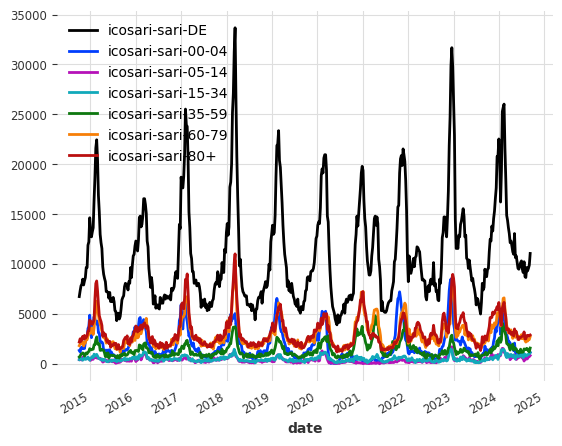

In [10]:
targets.plot()

<Axes: xlabel='date'>

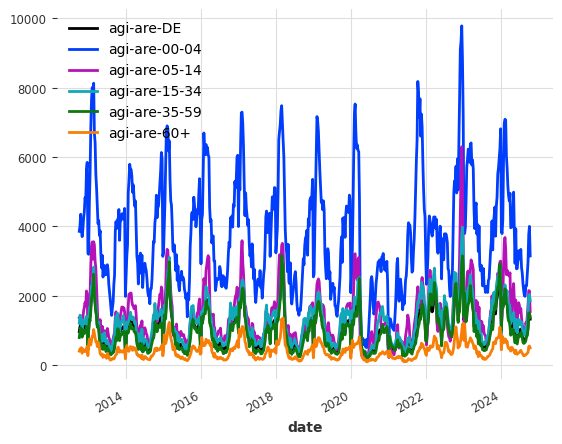

In [11]:
covariates.plot()

### Current forecast date

In [12]:
current_date = pd.Timestamp.now().date()
forecast_date = get_preceding_thursday(current_date)
forecast_date = str(forecast_date.date())
forecast_date

'2024-10-10'

# Train model

In [13]:
RANDOM_SEEDS = [1, 2, 3, 4, 5 , 6, 7, 8, 9, 10]

In [14]:
path = f'../models/realtime/{forecast_date}/'

In [15]:
os.makedirs(path, exist_ok=True)

In [16]:
for seed in RANDOM_SEEDS:
    model_path = path + f'{forecast_date}-lightgbm-{seed}.pt'
    print(model_path)
    model.model_params['random_state'] = seed
    model.fit(targets, past_covariates=covariates)
    model.save(model_path)

../models/realtime/2024-10-10/2024-10-10-lightgbm-1.pt
../models/realtime/2024-10-10/2024-10-10-lightgbm-2.pt
../models/realtime/2024-10-10/2024-10-10-lightgbm-3.pt
../models/realtime/2024-10-10/2024-10-10-lightgbm-4.pt
../models/realtime/2024-10-10/2024-10-10-lightgbm-5.pt
../models/realtime/2024-10-10/2024-10-10-lightgbm-6.pt
../models/realtime/2024-10-10/2024-10-10-lightgbm-7.pt
../models/realtime/2024-10-10/2024-10-10-lightgbm-8.pt
../models/realtime/2024-10-10/2024-10-10-lightgbm-9.pt
../models/realtime/2024-10-10/2024-10-10-lightgbm-10.pt
